**Homework 3, due Friday, January 30**

# Problem 1

**Winston, p. 472, Problem 2**. Instead of using Ford-Fulkerson, fill in the below linear program to solve the problem. DO NOT USE LOOPS or the Graph class from later in the notebook in your code.

In [13]:
%pip install ortools

In [14]:
from ortools.linear_solver import pywraplp

# Create the linear program solver.
solver = pywraplp.Solver.CreateSolver("GLOP")

# Construct the variables. Use REAL variables, not integer variables.
x_NY_CH = solver.NumVar(0, solver.infinity(), 'x_NY_CH')
x_NY_ME = solver.NumVar(0, solver.infinity(), 'x_NY_ME')
x_CH_DE = solver.NumVar(0, solver.infinity(), 'x_CH_DE')
x_CH_DA = solver.NumVar(0, solver.infinity(), 'x_CH_DA')
x_ME_DE = solver.NumVar(0, solver.infinity(), 'x_ME_DE')
x_ME_DA = solver.NumVar(0, solver.infinity(), 'x_ME_DA')
x_DE_LA = solver.NumVar(0, solver.infinity(), 'x_DE_LA')
x_DA_LA = solver.NumVar(0, solver.infinity(), 'x_DA_LA')

# Set the objective.
solver.Maximize(x_DE_LA + x_DA_LA)

# Add the constraints. DO NOT USE LOOPS.
solver.Add(x_NY_CH <= 500)
solver.Add(x_NY_ME <= 400)
solver.Add(x_CH_DE <= 300)
solver.Add(x_CH_DA <= 250)
solver.Add(x_ME_DE <= 200)
solver.Add(x_ME_DA <= 150)
solver.Add(x_DE_LA <= 400)
solver.Add(x_DA_LA <= 350)

# Flow conservation at Chicago
solver.Add(x_NY_CH == x_CH_DE + x_CH_DA)

# Flow conservation at Memphis
solver.Add(x_NY_ME == x_ME_DE + x_ME_DA)

# Flow conservation at Denver
solver.Add(x_CH_DE + x_ME_DE == x_DE_LA)

# Flow conservation at Dallas
solver.Add(x_CH_DA + x_ME_DA == x_DA_LA)

# Solve the LP and print the solution. DO NOT CHANGE ANYTHING PAST THIS POINT.
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
  print("Solution:")
  print(f"Optimal value = {solver.Objective().Value():0.2f}")
  print(f"{x_NY_CH} = {x_NY_CH.solution_value():0.2f}")
  print(f"{x_NY_ME} = {x_NY_ME.solution_value():0.2f}")
  print(f"{x_CH_DE} = {x_CH_DE.solution_value():0.2f}")
  print(f"{x_CH_DA} = {x_CH_DA.solution_value():0.2f}")
  print(f"{x_ME_DE} = {x_ME_DE.solution_value():0.2f}")
  print(f"{x_ME_DA} = {x_ME_DA.solution_value():0.2f}")
  print(f"{x_DE_LA} = {x_DE_LA.solution_value():0.2f}")
  print(f"{x_DA_LA} = {x_DA_LA.solution_value():0.2f}")
else:
  print("The problem does not have an optimal solution.")

Solution:
Optimal value = 750.00
x_NY_CH = 400.00
x_NY_ME = 350.00
x_CH_DE = 200.00
x_CH_DA = 200.00
x_ME_DE = 200.00
x_ME_DA = 150.00
x_DE_LA = 400.00
x_DA_LA = 350.00


# The Graph class

For the rest of the problems, I have implemented a Graph class for you to use. Look through the definition of Graph below, focusing on the comments and how to use the functions provided. Then carefully look at the shortest-path example afterwards.

We will be making heavy use of Python sets and dictionaries. You should familiarize yourself with them if you haven't seen them. There are many online resources for this, and you can ask questions on the Ed discussion board.

For undirected graphs, we use the unordered set {u,v} to represent the edge uv. This will pose a problem later since Python sets are "mutable" and therefore can't be used as keys in a dictionary. To circumvent this, we will represent undirected edges using an object called a "frozen set", which is a set that cannot be changed and therefore can be used as a key.

In [15]:
# Represents an undirected or directed graph. Loops are allowed but parallel
# edges are not.
class Graph:

  # Constructs a graph with no vertices or edges. Set directed to True if you
  # want a directed graph.
  def __init__(self, directed=False):
    self.vertices = set()
    self.outneighbors = {}
    self.inneighbors = {}
    self.directed = directed


  # Adds a vertex to a graph. A vertex can be any type of object. If the vertex
  # is already in the graph, this function does nothing. The new vertex will
  # will have no neighbors until you add edges with the next function.
  def add_vertex(self, vertex):
    if vertex in self.vertices:
      return
    self.vertices.add(vertex)
    self.outneighbors[vertex] = set()
    self.inneighbors[vertex] = set()


  # Adds an edge (vertex1, vertex2) to the graph. This is a directed edge if
  # directed is set to True, undirected otherwise. The two vertices must already
  # be in the graph, otherwise this function does nothing.
  def add_edge(self, vertex1, vertex2):
    if not(vertex1 in self.vertices and vertex2 in self.vertices):
      return
    self.outneighbors[vertex1].add(vertex2)
    self.inneighbors[vertex2].add(vertex1)
    if not self.directed:
      self.outneighbors[vertex2].add(vertex1)
      self.inneighbors[vertex1].add(vertex2)


  # Shortcut to construct a graph from a list of vertices and a list of edges.
  def graph_from_data(vertices, edges, directed=False):
    graph = Graph(directed=directed)
    for v in vertices:
      graph.add_vertex(v)
    for edge in edges:
      e = list(edge)
      if len(e) == 2:
        graph.add_edge(e[0],e[1])
      else:
        graph.add_edge(e[0],e[0])
    return graph


  # Returns the set of vertices of the graph.
  def get_vertices(self):
    return self.vertices


  # Returns the set of inneighbors of a vertex. For an undirected graph, this
  # is the same as the set of neighbors.
  def get_inneighbors(self, vertex):
    return self.inneighbors[vertex]


  # Returns the set of outneighbors of a vertex. For an undirected graph, this
  # is the same as the set of neighbors.
  def get_outneighbors(self, vertex):
    return self.outneighbors[vertex]


  # Returns the set of neighbors of a vertex. For a directed graph, this
  # gives both inneighbors and outneighbors.
  def get_neighbors(self, vertex):
    return self.inneighbors[vertex] | self.outneighbors[vertex]


  # Returns the set of edges. For a directed graph each edge will be an ordered
  # pair, and for an undirected graph each edge will be an unordered frozen set.
  def get_edges(self):
    if self.directed:
      return {(u,v) for u in self.vertices for v in self.outneighbors[u]}
    return {frozenset({u,v}) for u in self.vertices for v in self.outneighbors[u]}

Here is an example of how to implement finding the shortest path in a directed graph using Graph objects.

In [16]:
# Finds the shortest path from source to sink.
# "vertices" is a set or list of the vertices of the graph.
# "source" and "sink" must be in vertices.
# t is a dictionary. Each key is an ordered pair (u,v) where uv is a directed
# edge of the graph. The value t[(u,v)] is the time it takes to go along edge uv.
def shortest_path(vertices, source, sink, t):

  # First, we construct the Graph object from the given data.
  edges = t.keys()
  graph = Graph.graph_from_data(vertices, edges, directed=True)

  # Create the integer program solver.
  solver = pywraplp.Solver.CreateSolver("SAT")

  # Create one variable for each edge of the graph.
  x = {}      # We will store our variables in the dictionary x, with keys being
              # edges (u,v).
  for edge in edges:
    x[edge] = solver.IntVar(0,1,"") # Each variable is indexed by a different edge.

  # Set the objective.
  solver.Minimize(solver.Sum(t[edge]*x[edge] for edge in edges))


  # Create the constraints
  # Number of times going into each vertex (other than source and sink) must
  # equal number of times going out.
  for v in vertices:
    if v != source and v != sink:
      solver.Add(solver.Sum(x[(u,v)] for u in graph.get_inneighbors(v)) ==
                 solver.Sum(x[(v,u)] for u in graph.get_outneighbors(v)))

  # Must leave source once.
  solver.Add(solver.Sum(x[(source,u)] for u in graph.get_outneighbors(source)) == 1)

  # Must enter sink once.
  solver.Add(solver.Sum(x[(u,sink)] for u in graph.get_inneighbors(sink)) == 1)


  # Solve and return the solution.
  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    time = solver.Objective().Value()
    path = []
    current = source
    while current != sink:
      for edge in edges:
        if x[edge].solution_value() == 1 and edge[0] == current:
          path.append(edge)
          current = edge[1]
  else:
    time = None
    path = None

  return time, path

Here is a test of the above code, using the network from Winston, p. 414, Example 1.

In [17]:
vertices = [1,2,3,4,5,6]
t = {(1,2):4, (1,3):3, (2,4):3, (2,5):2, (3,5):3, (4,6):2, (5,6):2}

time, path = shortest_path(vertices,1,6,t)

print(time)
print(path)

8.0
[(1, 2), (2, 5), (5, 6)]


# Problem 2

We will redo Problem 1 using the Graph class. We will start by writing a general function for solving the max-flow problem.

In [18]:
# Finds the maximum flow from source to sink.
# "vertices" is a set or list of the vertices of the graph.
# "source" and "sink" must be in vertices.
# c is a dictionary. Each key is an ordered pair (u,v) where uv is a directed
# edge of the graph. The value c[(u,v)] is the capacity of the edge uv.
def max_flow(vertices, source, sink, c):

  # First, construct the graph from the given data. COMPLETE THIS.
  edges = c.keys()
  graph = Graph.graph_from_data(vertices, edges, directed=True)


  # Create the linear program solver
  solver = pywraplp.Solver.CreateSolver("GLOP")


  # Construct the variables.
  x = {}
  for edge in edges:
    x[edge] = solver.NumVar(0, solver.infinity(), "")


  # Set the objective.
  solver.Maximize(solver.Sum(x[(source,u)] for u in graph.get_outneighbors(source)))

  # Create the constraints.
  for edge in edges:
    solver.Add(x[edge] <= c[edge])

  for v in vertices:
    if v != source and v != sink:
      solver.Add(solver.Sum(x[(u,v)] for u in graph.get_inneighbors(v)) ==
                 solver.Sum(x[(v,u)] for u in graph.get_outneighbors(v)))

  # Solve and return the solution as a pair (m,f), where m is the objective
  # value and f is a dictionary. Each key of f is an edge (u,v), and f[(u,v)]
  # is the flow on that edge in the optimal solution.
  # DO NOT CHANGE ANYTHING PAST THIS POINT.
  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    m = solver.Objective().Value()
    f = {edge:x[edge].solution_value() for edge in edges}
  else:
    m = None
    f = None

  return m,f

Now use the function you just made to re-solve Problem 1.

In [19]:
vertices = ["NY", "CH", "ME", "DE", "DA", "LA"]
c = {("NY","CH"):500, ("NY","ME"):400, ("CH","DE"):300, ("CH","DA"):250,
     ("ME","DE"):200, ("ME","DA"):150, ("DE","LA"):400, ("DA","LA"):350}


# DO NOT CHANGE ANYTHING PAST THIS POINT.
m,f = max_flow(vertices, "NY", "LA", c)
print(f"Max calls = {m}")
print("Calls between each city:")
for edge in c.keys():
  print(f"{edge[0]} to {edge[1]}: {f[edge]:0.0f}")

Max calls = 750.0
Calls between each city:
NY to CH: 400
NY to ME: 350
CH to DE: 200
CH to DA: 200
ME to DE: 200
ME to DA: 150
DE to LA: 400
DA to LA: 350


# Problem 3

An *independent set* of a graph is a set of vertices such that no two vertices are adjacent. For example, in the following graph

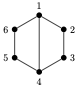

the sets {3,6} and {1,3,5} are independent sets, but {1,2,5} is not since 1 and 2 are adjacent.

Finding the largest independent set of a graph is another classic optimization problem. In this problem we will write a function to find a largest independent set of an undirected graph.

In [20]:
# This function accepts as input an object of the Graph class.
def max_independent_set(graph):

  # Obtains the vertices and edges of the graph for convenience.
  vertices = graph.get_vertices()
  edges = graph.get_edges()

  # Create the integer program solver.
  solver = pywraplp.Solver.CreateSolver("SAT")

  # Create the variables. Use comments to clarify.
  x = {}
  # x[v] = 1 if vertex v is in the independent set, 0 otherwise
  for v in vertices:
    x[v] = solver.IntVar(0, 1, "")


  # Set the objective.
  solver.Maximize(solver.Sum(x[v] for v in vertices))


  # Create the constraints. Complete this without adding more lines.
  for edge in edges:
    e = list(edge) # Converts edge from a set to a list with two elements.
    solver.Add(x[e[0]] + x[e[1]] <= 1)  # At most one endpoint of each edge can be in the set


  # Solve and return a maximum independent set. DO NOT CHANGE ANYTHING PAST
  # THIS POINT.
  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    independent_set = {v for v in vertices if x[v].solution_value() == 1}
  else:
    independent_set = None

  return independent_set

Test your function by running the below code. The graph is the one pictured above.

In [21]:
vertices = [1,2,3,4,5,6]
edges = [{1,2},{2,3},{3,4},{4,5},{5,6},{6,1},{1,4}]

graph = Graph.graph_from_data(vertices,edges)

independent_set = max_independent_set(graph)
print(independent_set)

{2, 4, 6}


# Problem 4

**Winston, p. 504, Problem 20.** Complete the following code to solve the problem.

In [22]:
# Construct the graph to use in the problem.
vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] # COMPLETE THIS
edges = [{'A','B'}, {'A','C'}, {'A','D'}, {'B','C'}, {'B','E'}, {'C','D'},
         {'C','F'}, {'D','G'}, {'E','F'}, {'F','G'}, {'E','G'}] # COMPLETE THIS. There should be 11 edges in total.

graph = Graph.graph_from_data(vertices,edges)

edges = graph.get_edges() # We do this because this makes all our edges frozen
                          # sets rather than sets. This is so we can use them
                          # as keys in the dictionary x below.


# Create the integer program solver.
solver = pywraplp.Solver.CreateSolver("SAT")

# Create the variables. Use comments to clarify.
x = {}
y = {}
for e in edges:
  x[e] = solver.IntVar(0, 1, "")  # x[e] = 1 if edge e is assigned to a sales rep, 0 otherwise
for v in vertices:
  y[v] = solver.IntVar(0, 1, "")  # y[v] = 1 if state v is assigned to a sales rep, 0 otherwise

# Set the objective.
students = {'A':43, 'B':29, 'C':42, 'D':21, 'E':56, 'F':18, 'G':71}
solver.Maximize(solver.Sum(students[v] * y[v] for v in vertices))


# Create the constraints. You can use frozenset({u,v}) to specify the edge uv.
solver.Add(solver.Sum(x[e] for e in edges) == 2)
# If a state is assigned, it must be part of exactly one selected edge
for v in vertices:
  # Get all edges incident to vertex v
  incident_edges = [e for e in edges if v in e]
  solver.Add(solver.Sum(x[e] for e in incident_edges) == y[v])

# Each selected edge means both its endpoints are assigned
for e in edges:
  e_list = list(e)
  solver.Add(y[e_list[0]] >= x[e])
  solver.Add(y[e_list[1]] >= x[e])


# Solve and print the solution. DO NOT CHANGE ANYTHING PAST THIS POINT.
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
  objective = solver.Objective().Value()
  locations = [tuple(e) for e in edges if x[e].solution_value() == 1]
else:
  objective = None
  locations = None
print(f"Students assigned: {objective:0.0f}")
print(f"Locations: {locations}")

Students assigned: 212
Locations: [('A', 'C'), ('G', 'E')]


**Submission:** As usual, make sure you click "Run all", and all output is shown. Submit on Gradescope.